## Prepare Environment

### Modules

In [1]:
from pathlib import Path
from typing import Union

import numpy as np
import pandas as pd
import torch
import scvi
import scanpy as sc
import sklearn

import matplotlib.pyplot as plt


/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(
    torch.backends.mps.is_available(),
    torch.cuda.is_available()
)

True False


### Utils

In [3]:
def create_folders(base_path: str, structure: dict, current_path: Union[str, Path] = None) -> None:
    if current_path is None:
        current_path = Path(base_path)
    Path(current_path).mkdir(exist_ok=True)
    for key, value in structure.items():
        new_path = current_path / str(key)
        if isinstance(value, dict):
            Path(new_path).mkdir(exist_ok=True)
            create_folders(base_path, value, new_path)

### Folder Structure

In [4]:
create_folders(
    str(Path.cwd()),
    {
        "data": {
            "inputQuery": {},
            "inputRef": {},
            "nico_out": {},
        }
    }
)

### Dataloading

In [5]:
adata_sp = sc.read_h5ad(Path.cwd() / "data" / "nico_out" / "nico_celltype_annotation.h5ad")
adata_sc = sc.read_h5ad(Path.cwd() / "data" / "inputRef" / "input_ref.h5ad")
adata_sp, adata_sc

(AnnData object with n_obs × n_vars = 7416 × 203
     obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct', 'leiden0.4', 'leiden0.5', 'nico_ct'
     var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'
     uns: 'leiden', 'leiden0.5_colors', 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial'
     varm: 'PCs'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 2239 × 32287
     obs: 'cluster')

### Dataprep

In [6]:
# Choose one celltype from the available shared types to filter adata objects with
set.intersection(
    set(adata_sc.obs["cluster"]),
    set(adata_sp.obs["nico_ct"])
)

{'BZE',
 'Blood vasc.',
 'Cycling/GC B cell',
 'Glial',
 'Goblet',
 'Lymphatic',
 'MZE',
 'Macrophage',
 'Paneth',
 'Plasma',
 'Rest B',
 'Stem/TA',
 'Stroma',
 'T cell',
 'TZE',
 'Tuft',
 'cDC/monocyte',
 'neurons/enteroendocrine',
 'pDC'}

In [7]:
celltype = "Stem/TA"
adata_sc_filtered = adata_sc[adata_sc.obs["cluster"] == celltype].copy()
adata_sp_filtered = adata_sp[adata_sp.obs["nico_ct"] == celltype].copy()
adata_sc_filtered, adata_sp_filtered

(AnnData object with n_obs × n_vars = 420 × 32287
     obs: 'cluster',
 AnnData object with n_obs × n_vars = 997 × 203
     obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct', 'leiden0.4', 'leiden0.5', 'nico_ct'
     var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'
     uns: 'leiden', 'leiden0.5_colors', 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial'
     varm: 'PCs'
     obsp: 'connectivities', 'distances')

## Benchmarking

In [24]:
model_nmf = sklearn.decomposition.NMF(
    n_components=3,
)
W = model_nmf.fit_transform(
   X=adata_sc_filtered.X.transpose() 
)
H = model_nmf.components_
sklearn.metrics.mean_squared_error(
    adata_sc_filtered.X.transpose().toarray(),
    W @ H
)

/opt/homebrew/Caskroom/miniforge/base/envs/scvi_mps-env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


4.443472385406494

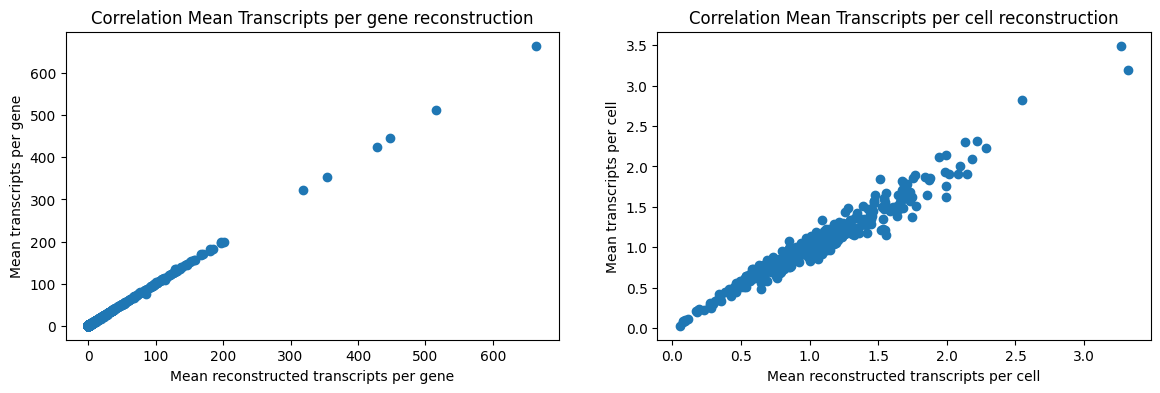

Correlation Coeff Gene Reconstruction: 0.9999169659403755 
Correlation Coeff Cell Reconstruction: 0.9769244989348445


In [25]:
fig, axs = plt.subplots(1, 2, figsize=(14,4))

axs[0].scatter(
    adata_sc_filtered.X.transpose().toarray().mean(axis=1),
    (W @ H).mean(axis=1),
)
axs[0].set_title("Correlation Mean Transcripts per gene reconstruction")
axs[0].set_xlabel("Mean reconstructed transcripts per gene")
axs[0].set_ylabel("Mean transcripts per gene")

axs[1].scatter(
    adata_sc_filtered.X.transpose().toarray().mean(axis=0),
    (W @ H).mean(axis=0),
)
axs[1].set_title("Correlation Mean Transcripts per cell reconstruction")
axs[1].set_xlabel("Mean reconstructed transcripts per cell")
axs[1].set_ylabel("Mean transcripts per cell")
plt.show()

print(
    f"Correlation Coeff Gene Reconstruction: {np.corrcoef(adata_sc_filtered.X.transpose().toarray().mean(axis=1), (W @ H).mean(axis=1))[0, 1]}",
    f"\nCorrelation Coeff Cell Reconstruction: {np.corrcoef(adata_sc_filtered.X.transpose().toarray().mean(axis=0), (W @ H).mean(axis=0))[0, 1]}",
)

In [28]:
np.isin(adata_sc_filtered.var_names, adata_sp_filtered.var_names)

array([False, False, False, ..., False, False, False])

In [32]:
adata_sp_filtered

AnnData object with n_obs × n_vars = 997 × 203
    obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct', 'leiden0.4', 'leiden0.5', 'nico_ct'
    var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'
    uns: 'leiden', 'leiden0.5_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [37]:
list(adata_sp_filtered.var_names)[0:10]

['Acsl1',
 'Acta2',
 'Ada',
 'Adgrd1',
 'Adgrf5',
 'Adra1a',
 'Adra1b',
 'Adra2a',
 'Adra2b',
 'Adrb1']

In [41]:
H

array([[21.261753  , 28.685858  , 16.048298  , ...,  0.12589277,
         0.5273324 ,  0.        ],
       [ 1.7029352 ,  0.        , 13.323027  , ...,  2.792134  ,
         1.4286821 ,  0.93393105],
       [17.670866  , 10.896952  , 15.449147  , ...,  0.        ,
         0.        ,  0.08054154]], dtype=float32)

In [33]:
W[np.isin(adata_sc_filtered.var_names, adata_sp_filtered.var_names)]

array([[2.70334240e-02, 8.11406877e-03, 2.19436903e-02],
       [0.00000000e+00, 7.13239424e-04, 4.37573559e-04],
       [1.54552385e-01, 6.15503341e-02, 3.71021450e-01],
       [2.38371348e+00, 4.98328149e-01, 1.05160451e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.57845708e-03, 1.94392484e-02, 1.23392949e-02],
       [0.00000000e+00, 0.00000000e+00, 7.51169049e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.12632974e-03, 9.96424700e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.56025058e-04, 7.42322940e-04, 9.04001718e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.91159270e-04, 0.00000000e+00, 1.61069096e-04],
       [1.46871794e-03, 0.00000000e+00, 0.00000000e+00],
       [1.31738640e-03, 0.00000000e+00, 0.00000000e+00],
       [4.81556654e-02, 1.29597215e-02, 1.46526396e-01],
       [4.03857935e-04, 0.00000